# **Word Embeddings 📚**



### **Basic Word Context Matrix**

Simple exercise of programming a Word Context Matrix Class that generates the matrix with a specific window size, corpus and tokenizer

In [ ]:
import scipy as sp
import numpy as np
import spacy

# basic WordContextMatrix
class WordContextMatrix:
  def __init__(self, vocab_size, window_size, dataset, tokenizer):
    
    self.wcm = np.full((vocab_size+1, vocab_size+1), 0) # matrix
    self.window_size = window_size # int
    self.dataset = dataset # list(string): list of documents
    self.tokenizer = tokenizer # tokenizer: string -> list(string)
    self.vocab = None # tokens list
    self.index = None # dictionary --> token: index in matrix
    
    
  def build_vocab(self):
    tokens = np.array(["[UNK]"]) # token for words not in vocab
    for doc in self.dataset:
      doc_tokens = self.tokenizer(doc)
      tokens = np.append(tokens, doc_tokens)
  
    self.vocab = np.unique(tokens)
  
  def build_matrix(self):
    self.index = {} #token: index
    for i in range(len(self.vocab)):
      self.index[self.vocab[i]] = i

    # coocurrences calculus
    for doc in self.dataset:
      tokenized_doc = self.tokenizer(doc)
      # for each token a sum
      for i in range(len(tokenized_doc)):
        token = tokenized_doc[i] 
        if not token in self.vocab:
          token = "[UNK]"
        index_token = self.index[token]
        # tokens to the left
        for j in range(max(0, i - self.window_size), i):
          token_left = tokenized_doc[j]
          if not token in self.vocab:
            token_left = "[UNK]"
          index_token_left = self.index[token_left]
          self.wcm[index_token][index_token_left] += 1 # sum
        # tokens to the right
        for k in range(i+1, min(len(tokenized_doc), i+1 + self.window_size)):
          token_right = tokenized_doc[k]
          if not token in self.vocab:
            token_right = "[UNK]"
          index_token_right = self.index[token_right]
          self.wcm[index_token][index_token_right] += 1 # sum

  # returns matrix as a dictionary(token) = list of coocurrences
  def get_matrix(self):
    matrix_dic = {}
    for token in self.index.keys():
      i = self.index[token]
      matrix_dic[token] = self.wcm[:, i]
    return matrix_dic


In [ ]:
!python -m spacy download es_core_news_sm
import pandas as pd

2023-05-18 22:25:41.806813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 29.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [ ]:
# simple corpus
corpus = [
  "I like deep learning.",
  "I like NLP.",
  "I enjoy flying."
]

nlp = spacy.load("es_core_news_sm")

# tokenization
def tokenize_text(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return tokens

# simple test 
WCM = WordContextMatrix(8, 1, corpus, tokenize_text)
WCM.build_vocab()
WCM.build_matrix()

print(f"Dataset: {corpus}")
print("Result: ")

# print with pandas
df = pd.DataFrame(WCM.get_matrix(), index = WCM.index, columns = WCM.index)
print(df)



Dataset: ['I like deep learning.', 'I like NLP.', 'I enjoy flying.']
Result: 
          .  I  NLP  [UNK]  deep  enjoy  flying  learning  like
.         0  0    1      0     0      0       1         1     0
I         0  0    0      0     0      1       0         0     2
NLP       1  0    0      0     0      0       0         0     1
[UNK]     0  0    0      0     0      0       0         0     0
deep      0  0    0      0     0      0       0         1     1
enjoy     0  1    0      0     0      0       1         0     0
flying    1  0    0      0     0      1       0         0     0
learning  1  0    0      0     1      0       0         0     0
like      0  2    1      0     1      0       0         0     0


### **Word2Vec and Gensim FastText**

The goal is to compare the embeddings of the two different models: Word2Vec and [FastText](https://radimrehurek.com/gensim/models/fasttext.html) trained with the same corpus of Simpson's dialogue 

In [ ]:
import re  
import pandas as pd 
from time import time  
from collections import defaultdict 
import string 
import multiprocessing
import os
import gensim
import sklearn
from sklearn import linear_model
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, cohen_kappa_score, classification_report
import nltk
from nltk.corpus import stopwords as stws
nltk.download('stopwords')

# word2vec
from gensim.models import Word2Vec, KeyedVectors, FastText
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data_file = "dialogue-lines-of-the-simpsons.zip"
df = pd.read_csv(data_file)
stopwords = pd.read_csv(
    'https://raw.githubusercontent.com/Alir3z4/stop-words/master/english.txt'
).values
stopwords = Counter(stopwords.flatten().tolist())
df = df.dropna().reset_index(drop=True) # Quitar filas vacias

**Exploration**:

In [ ]:
df.head(12)

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
5,Martin Prince,I don't think there's anything left to say.
6,Edna Krabappel-Flanders,Bart?
7,Bart Simpson,Victory party under the slide!
8,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!
9,Landlady,"Hey, hey, he Moved out this morning. He must h..."


In [ ]:
df.describe()

,raw_character_text,spoken_words
count,131853,131853
unique,6272,121757
top,Homer Simpson,No.
freq,27850,304


In [ ]:
# punctuation cleaning and tokenization
punctuation = string.punctuation + "«»“”‘’…—"
stopwords = stws.words('english')

# stopwords preprocess
for i in range(len(stopwords)): 
  stopwords[i] = stopwords[i].translate(str.maketrans(
      '', '', punctuation)).lower()

stopwords.append("im") 
print(f"Lista de stopwords: {stopwords}")

def simple_tokenizer(doc, lower=True):
    if lower:
      tokenized_doc = doc.translate(str.maketrans(
          '', '', punctuation)).lower().split()

    else:
      tokenized_doc = doc.translate(str.maketrans('', '', punctuation)).split()
    tokenized_doc = [
        token for token in tokenized_doc if token.lower() not in stopwords
    ]
    return tokenized_doc

cleaned_content = [simple_tokenizer(doc) for doc in df["spoken_words"]]

print(f'Original: {df["spoken_words"][0]}')
print(f"After: {cleaned_content[0]}")

Lista de stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [ ]:
length_avg = 0
for doc in cleaned_content:
  length_avg += len(doc)
print(f"Token average per document: {length_avg/len(cleaned_content)}")

Promedio de tokens por documento: 5.319598340576248


In [ ]:
from nltk import FreqDist

all_tokens = []
for doc in cleaned_content:
  all_tokens += doc
fdist1 = FreqDist(all_tokens)

print("10 most common tokens: ")
print(fdist1.most_common(10))



10 tokens mas comunes: 
[('oh', 8122), ('well', 7014), ('like', 5952), ('get', 5213), ('know', 4710), ('one', 4642), ('thats', 4478), ('hey', 4276), ('homer', 4111), ('right', 4024)]


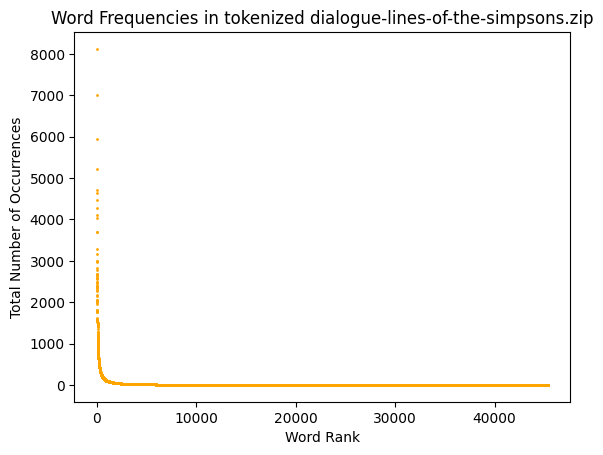

In [ ]:
import matplotlib.pyplot as plt

word_rank = [range(1, 1+ len(fdist1.most_common()))]
word_freq = [pair[1] for pair in fdist1.most_common()]

plt.title("Word Frequencies in tokenized dialogue-lines-of-the-simpsons.zip")
plt.ylabel("Total Number of Occurrences")
plt.xlabel("Word Rank")
plt.scatter(
    word_rank,
    word_freq,
    color="orange",
    s=1)
plt.show()

In [ ]:
# Phrases extraction with Gensim
phrases = Phrases(cleaned_content, min_count=100, progress_per=5000, connector_words={"id","im","lets","dont","ive","whats","youve","weve","cant","lets"}) 
bigram = Phraser(phrases)
sentences = bigram[cleaned_content]

In [ ]:
res = set()
for doc in sentences:
  for token in doc:
    if "_" in token:
      res.add(token)

print("Phrases found:")
print(res)
print("Total:")
print(len(res))

Lista de frases encontradas:
{'haw_haw', 'woo_hoo', 'mr_simpson', 'wait_wait', 'whoa_whoa', 'ha_ha', 'mrs_simpson', 'ow_ow', 'blah_blah', 'years_ago', 'ice_cream', 'la_la', 'oh_god', 'looks_like', 'homer_simpson', 'principal_skinner', 'itchy_scratchy', 'sideshow_bob', 'mr_burns', 'thousand_dollars', 'wait_minute', 'heh_heh'}
Total:
22


In [ ]:
# Model definition
simpsons_w2v = Word2Vec(min_count=10,
                      window=1,
                      negative=20, # noise words to be drawn w negative sampling
                      sg=0, # cBoW
                      workers=multiprocessing.cpu_count())

In [ ]:
simpsons_w2v.build_vocab(sentences, progress_per=10000)

In [ ]:
# training
t = time()
simpsons_w2v.train(sentences, total_examples=simpsons_w2v.corpus_count, epochs=5, report_delay=10)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.3 mins


In [ ]:
simpsons_w2v.init_sims(replace=True)

<ipython-input-50-0591ccad5a9b>:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  simpsons_w2v.init_sims(replace=True)


In [ ]:
# FastText definition
simpsons_ft = FastText(min_count=10,
                      window=1,
                      vector_size=200,
                      negative=20, # noise words to be drawn w negative sampling
                      workers=multiprocessing.cpu_count())

In [ ]:
simpsons_ft.build_vocab(sentences, progress_per=10000)

In [ ]:
# training
t = time()
simpsons_ft.train(sentences, total_examples=simpsons_ft.corpus_count, epochs=5, report_delay=10)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.58 mins


In [ ]:
simpsons_ft.init_sims(replace=True)

<ipython-input-54-b6ea9b275edd>:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  simpsons_ft.init_sims(replace=True)


**Excercise 2**: Find the most similar words to the following: Lisa, Bart, Homer, Marge. What is the difference between both results? Why does this happen? Now try comparing "Liisa" in both models (with a double i). When would you choose one over the other?**(0.5 puntos)**

**Respuesta**:

In [ ]:
print("Palabras mas similares a lisa con word2vec: ")
simpsons_w2v.wv.most_similar(positive=["lisa"])

Palabras mas similares a lisa con word2vec: 


[('bart', 0.9504731297492981),
 ('marge', 0.8645347356796265),
 ('abe', 0.8591281771659851),
 ('maggie', 0.8530220985412598),
 ('j', 0.8061081171035767),
 ('honey', 0.7798136472702026),
 ('grampa', 0.7696352005004883),
 ('family', 0.7553428411483765),
 ('eliza', 0.7449787855148315),
 ('abraham', 0.7419325113296509)]

In [ ]:
print("Palabras mas similares a lisa con fasttext: ")
simpsons_ft.wv.most_similar(positive=["lisa"])

Palabras mas similares a lisa con fasttext: 


[('bart', 0.9722647666931152),
 ('marge', 0.9203872084617615),
 ('lisas', 0.9126348495483398),
 ('lis', 0.9034671187400818),
 ('maggie', 0.8925299644470215),
 ('abe', 0.8723599910736084),
 ('margie', 0.8676388263702393),
 ('bartdude', 0.8624825477600098),
 ('bartholomew', 0.8513044118881226),
 ('j', 0.8432864546775818)]

In [ ]:
print("Palabras mas similares a bart con word2vec: ")
simpsons_w2v.wv.most_similar(positive=["bart"])

Palabras mas similares a bart con word2vec: 


[('lisa', 0.9504731893539429),
 ('abe', 0.8789340257644653),
 ('marge', 0.8668800592422485),
 ('maggie', 0.8637741804122925),
 ('grampa', 0.8222106695175171),
 ('j', 0.7970658540725708),
 ('son', 0.7930171489715576),
 ('honey', 0.7895950675010681),
 ('milhouse', 0.7872251868247986),
 ('family', 0.7676609754562378)]

In [ ]:
print("Palabras mas similares a bart con fasttext: ")
simpsons_ft.wv.most_similar(positive=["bart"])

Palabras mas similares a bart con fasttext: 


[('lisa', 0.9722647666931152),
 ('marge', 0.9281340837478638),
 ('lisas', 0.9153075814247131),
 ('lis', 0.9018505811691284),
 ('maggie', 0.897013783454895),
 ('bartdude', 0.8931506872177124),
 ('abe', 0.8890058398246765),
 ('margie', 0.8839731812477112),
 ('barf', 0.8686850070953369),
 ('bartholomew', 0.8664108514785767)]

In [ ]:
print("Palabras mas similares a homer con word2vec: ")
simpsons_w2v.wv.most_similar(positive=["homer"])

Palabras mas similares a homer con word2vec: 


[('homie', 0.858966588973999),
 ('grampa', 0.854986846446991),
 ('apu', 0.8388792872428894),
 ('mr_burns', 0.8250542283058167),
 ('honey', 0.8173046112060547),
 ('mr_simpson', 0.8169143199920654),
 ('sweetie', 0.8159830570220947),
 ('daughter', 0.8114054203033447),
 ('principal_skinner', 0.8100494146347046),
 ('son', 0.8009876012802124)]

In [ ]:
print("Palabras mas similares a homer con fasttext: ")
simpsons_ft.wv.most_similar(positive=["homer"])

Palabras mas similares a homer con fasttext: 


[('homey', 0.9325317144393921),
 ('honey', 0.906828761100769),
 ('homers', 0.8984987735748291),
 ('honeymoon', 0.8851144313812256),
 ('homie', 0.8829176425933838),
 ('honestly', 0.8660751581192017),
 ('barney', 0.8640583753585815),
 ('daddy', 0.8576154708862305),
 ('honesty', 0.8566398620605469),
 ('margie', 0.8565850257873535)]

In [ ]:
print("Palabras mas similares a marge con word2vec: ")
simpsons_w2v.wv.most_similar(positive=["marge"])

Palabras mas similares a marge con word2vec: 


[('abe', 0.8698983788490295),
 ('bart', 0.866879940032959),
 ('lisa', 0.8645347356796265),
 ('honey', 0.8294832110404968),
 ('son', 0.818108081817627),
 ('maggie', 0.8111215829849243),
 ('grampa', 0.8068246841430664),
 ('homer', 0.8007686734199524),
 ('sweetie', 0.7910235524177551),
 ('homie', 0.7854115962982178)]

In [ ]:
print("Palabras mas similares a marge con fasttext: ")
simpsons_ft.wv.most_similar(positive=["marge"])

Palabras mas similares a marge con fasttext: 


[('margie', 0.9463471174240112),
 ('bart', 0.9281342029571533),
 ('lisa', 0.9203872680664062),
 ('abe', 0.9097050428390503),
 ('bartdude', 0.8944185972213745),
 ('maggie', 0.8915013074874878),
 ('marges', 0.8878536224365234),
 ('lisas', 0.8870899677276611),
 ('lis', 0.8814953565597534),
 ('bartholomew', 0.8787049055099487)]

In [ ]:
print("Palabras mas similares a liisa con fasttext: ")
simpsons_ft.wv.most_similar(positive=["liisa"])

Palabras mas similares a liisa con fasttext: 


[('lisa', 0.9521167874336243),
 ('lisas', 0.9404617547988892),
 ('bart', 0.9250702857971191),
 ('lil', 0.9159604907035828),
 ('bartholomew', 0.9091137051582336),
 ('lima', 0.8987029790878296),
 ('limo', 0.8952091932296753),
 ('lie', 0.8937951326370239),
 ('lis', 0.8936484456062317),
 ('list', 0.8922975063323975)]

In [ ]:
print("Palabras mas similares a liisa con w2vec: ")
#simpsons_w2v.wv.most_similar(positive=["liisa"])
print("No existe un vector para liisa")

Palabras mas similares a liisa con w2vec: 
No existe un vector para liisa


In [ ]:
# búsqueda del término "homey" encontrado en palabras similares de "homer"
df[df["spoken_words"].str.contains("Homey")].head(10)

,raw_character_text,spoken_words
7758,Marge Simpson,"Oh, Homey! Are you all right?"
15838,Homer Simpson,"I love you, Homey. Heh, heh, heh. I don't need..."
15956,Marge Simpson,"Homey, I'm very proud of you, but don't you th..."
16047,Marge Simpson,"That was a very nice thing you did, Homey."
17012,Marge Simpson,"Homey, you know, it's funny -- both my mother ..."
19374,Marge Simpson,"Oh, Homey, what's--"
38961,Marge Simpson,"It's the same basic bear, Homey."
45910,Marge Simpson,"Of course, Homey. Aren't you thinking about me?"
47457,Marge Simpson,"Ohhh, Homey, is that what's bothering you?"
49451,Marge Simpson,"Now Homey, you know, Ned and the boys need us...."


In [ ]:
# búsqueda del término "lil" encontrado en palabras similares de "lisa"
df[df["spoken_words"].str.contains("Lil")].head(10)

,raw_character_text,spoken_words
29006,C. Montgomery Burns,Who should appear but the unrequited love of m...
29007,C. Montgomery Burns,I took Lily to the local cinematorium...
29012,C. Montgomery Burns,"Oh, there was a terrible scandal. Lily's famil..."
89865,Lillian Hellman,"Don't forget me, Lillian Hellman! Smoking gave..."
96397,Hooded Figures,"She is Lilith, who leadeth forth the hordes of..."
96483,Gwendolyn,"Goddess Lilith, who knows our hearts are pure..."
115211,C. Montgomery Burns,"I had a spring in my step like that once, back..."
115212,MR. BURNS.,Lilah ran a little crepe stand in the 7th arro...
115219,C. Montgomery Burns,It looked a lot better in my memory. But do yo...
115262,C. Montgomery Burns,Lilah's alive?!


In [ ]:
# búsqueda del término "margie" encontrado en palabras similares de "marge"
df[df["spoken_words"].str.contains("Margie")].head(10)

,raw_character_text,spoken_words
19698,Mr. Bouvier,"Goodbye, Margie. Be a good girl, now."
19702,Jacqueline Bouvier,"Margie, oh come back!"
51421,Bart Simpson,The kids are saying if you say Bloody Margie f...
74263,Homer Simpson,And you're my Margie-wargie-bargie-fargie-garg...
84975,Wife,Mr. Simpson! / You good man! / We happy see yo...
87524,Homer Simpson,"What?! Oh my God, my sweet Margie! Okay, liste..."
106500,Homer Simpson,"Everything's a rip-off of ""The Honeymooners."" ..."
125104,Jacqueline Bouvier,"Wait, Margie. Before you go out that door, let..."


**Comparation**

Both models yielded good results, providing other characters as similar words, their nicknames, nouns, and even alternative spellings of the names. The difference is that FastText captured the morphology of the words, delivering nicknames for the same characters. For example, for "Marge," it provided "Margie" as a similar vector, and for "Homer," it provided "Homey." However, FastText also considered morphologically similar words as similar vectors, even if they were not semantically similar. For instance, "Lisa" was found to be similar to "Lima" or "Lil," which Word2Vec did not do. This occurs because, unlike Word2Vec, FastText breaks down words into n-grams and performs comparisons between them.

The choice of which model to use depends on the task you plan to perform with the embeddings. Specifically, if the task involves obtaining embeddings for words that were not used in the model's training, FastText would be preferred.

In the case of "Liisa," FastText can find similar words in the corpus, but Word2Vec cannot because it is not found in the vocabulary, and as mentioned, Word2Vec does not break down any words.


### **Embeddings for classification**

Now we will use the embeddings we just calculated to classify words based on their polarity (positive or negative).

For this, we will use the AFINN lexicon included in the task, which consists of a list of words and a 1 if their connotation is positive and a -1 if it is negative.

In [ ]:
# for words not in vocab
def try_apply(model, word):
    try:
        aux = model[word]
        return True
    except KeyError:
        #logger.error('Word {} not in dictionary'.format(word))
        return False

In [ ]:
df_afinn =  pd.read_csv("AFINN_full.csv", header = None, sep = '	').rename(columns = {0: "word", 1: "Category"})

In [ ]:
df_afinn["can_vec"] = df_afinn["word"].apply(lambda x: try_apply(simpsons_w2v.wv, x))
df_w2v = df_afinn[df_afinn["can_vec"] == True]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_w2v["word"], df_w2v["Category"], random_state=0, test_size=0.1, stratify=df_w2v["Category"])

In [ ]:
from sklearn.base import BaseEstimator
class Doc2VecTransformer(BaseEstimator):
    """ Transforma tweets a representaciones vectoriales usando algún modelo de Word Embeddings.
    """
    
    def __init__(self, model):
        self.model = model.wv 
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        doc_embeddings = []
        
        for doc in X:
            doc_embeddings.append(self.model[doc])
        return np.array(doc_embeddings)

In [ ]:
from sklearn.pipeline import Pipeline
clf = LogisticRegression(max_iter=1000000)
pipeline = Pipeline([('doc2vec', Doc2VecTransformer(simpsons_w2v)), ('clf', clf)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('doc2vec',
                 Doc2VecTransformer(model=<gensim.models.keyedvectors.KeyedVectors object at 0x7f35785d0c40>)),
                ('clf', LogisticRegression(max_iter=1000000))])

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
conf_matrix_w2v = confusion_matrix(y_test, y_pred)

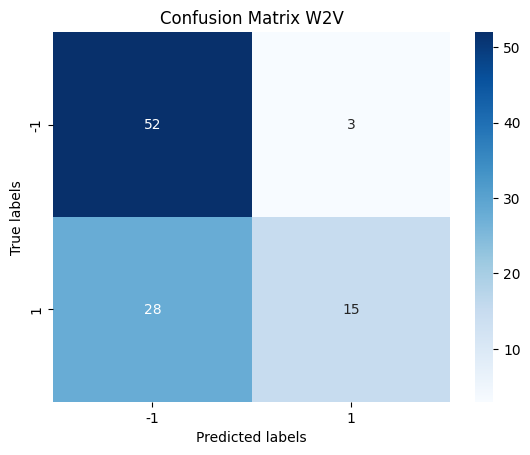

In [ ]:
import seaborn as sns

ax = plt.subplot()
sns.heatmap(conf_matrix_w2v, annot=True, fmt='g', ax=ax, cmap="Blues");

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix W2V'); 
ax.xaxis.set_ticklabels(['-1', '1']); ax.yaxis.set_ticklabels(['-1', '1']);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.65      0.95      0.77        55
           1       0.83      0.35      0.49        43

    accuracy                           0.68        98
   macro avg       0.74      0.65      0.63        98
weighted avg       0.73      0.68      0.65        98



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_afinn["word"], df_afinn["Category"], random_state=0, test_size=0.1, stratify=df_afinn["Category"])

In [ ]:
clf = LogisticRegression(max_iter=1000000)
pipeline = Pipeline([('doc2vec', Doc2VecTransformer(simpsons_ft)), ('clf', clf)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('doc2vec',
                 Doc2VecTransformer(model=<gensim.models.fasttext.FastTextKeyedVectors object at 0x7f3747789cc0>)),
                ('clf', LogisticRegression(max_iter=1000000))])

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

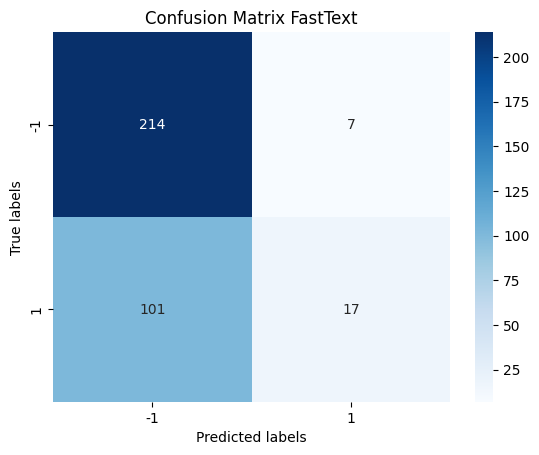

In [ ]:
import seaborn as sns

ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax, cmap="Blues");

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix FastText'); 
ax.xaxis.set_ticklabels(['-1', '1']); ax.yaxis.set_ticklabels(['-1', '1']);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.68      0.97      0.80       221
           1       0.71      0.14      0.24       118

    accuracy                           0.68       339
   macro avg       0.69      0.56      0.52       339
weighted avg       0.69      0.68      0.60       339



**Resultados de la clasificación**

Overall, both models do not achieve optimal results. This could be due to the corpus they were trained on not being sufficiently general and/or extensive enough for them to generate embeddings that capture the semantic/syntactic sense of words. Thus, when trying to classify words based on their polarity, which implies being able to grasp the general sense of the word, they do not perform well. It is worth noting that both models obtained decent results in identifying negative lexicons, reaching an f1 score of $0.80$ with FastText. The problem was that they also classified positive lexicons as negative. This could be because the corpus was heavily skewed towards the negative side, with little usage of words considered positive.

One way to improve both models could be to use pre-trained word embeddings with a sufficient amount of data to produce general representations, as opposed to representations tied to the context from which they were obtained, as was the case in the previous scenario.

**Bonus**: Repit the exercise with larger pre-trained models

In [ ]:
import gensim.downloader as api

# Pre-trained vectors trained on a part of the Google News dataset 
# (about 100 billion words). The model contains 300-dimensional vectors for 
# 3 million words and phrases. The phrases were obtained using a simple 
# data-driven approach described in 'Distributed Representations of Words and 
# Phrases and their Compositionality' 

model_w2v_wiki = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
class Doc2VecTransformer2(BaseEstimator):
    """ Transforma tweets a representaciones vectoriales usando algún modelo de Word Embeddings.
    """
    
    def __init__(self, model):
        # extraemos los embeddings desde el objeto contenedor. ojo con esta parte.
        self.model = model
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        doc_embeddings = []
        
        for doc in X:
            doc_embeddings.append(self.model[doc])
        return np.array(doc_embeddings)

In [ ]:
# not found words eliminatino
notfound = 0
df_afinn2 = df_afinn
for word in df_afinn["word"]:
  try:
    model_w2v_wiki.get_index(word)
  except:
    notfound +=1
    df_afinn2 = df_afinn2[df_afinn2.word != word]

print("Total words deleted: ")
print(notfound)

Total de palabras eliminadas:
158


In [ ]:
from sklearn.pipeline import Pipeline

# clasificacion, misma logica que el fasttext creado
X_train, X_test, y_train, y_test = train_test_split(df_afinn2["word"], 
                                                    df_afinn2["Category"], 
                                                    random_state=0, 
                                                    test_size=0.1, 
                                                    stratify=df_afinn2["Category"])

clf = LogisticRegression(max_iter=1000000)
pipeline = Pipeline([('doc2vec', Doc2VecTransformer2(model_w2v_wiki)), ('clf', clf)])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('doc2vec',
                 Doc2VecTransformer2(model=<gensim.models.keyedvectors.KeyedVectors object at 0x7f379a2365c0>)),
                ('clf', LogisticRegression(max_iter=1000000))])

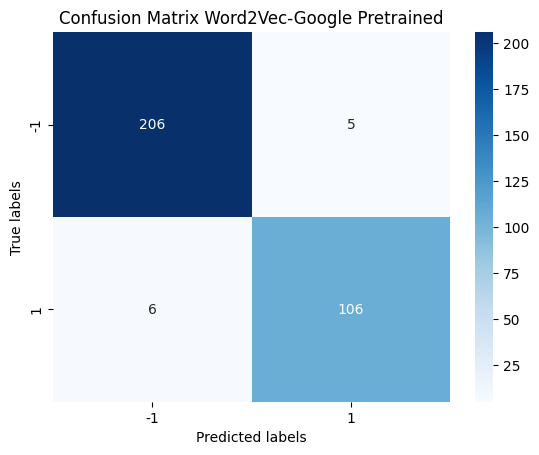

In [ ]:
import matplotlib.pyplot as plt

y_pred = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# visualizacion matriz de confusion
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax, cmap="Blues");

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Word2Vec-Google Pretrained'); 
ax.xaxis.set_ticklabels(['-1', '1']); ax.yaxis.set_ticklabels(['-1', '1']);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.97      0.98      0.97       211
           1       0.95      0.95      0.95       112

    accuracy                           0.97       323
   macro avg       0.96      0.96      0.96       323
weighted avg       0.97      0.97      0.97       323

